In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import cv2
from PIL import Image
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch.nn import functional as F
from torch import optim
import mlflow
import json
import hydra
from omegaconf import DictConfig, OmegaConf
import albumentations as A
import random
import shutil
import sys
import time
import datetime

__file__ = "/workdir/seg-laparo/make_video/main_frame.py"
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
from utils import *
from implementations import *

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Yu Mincho', 'Times New Roman']

In [2]:
class cfg:
    device = "cuda:2"
    multi_gpu = True
    multi_device_ids = [2, 3]
    class model_info:
        model =  ""
        in_channels = 3
        out_channels = 1
        batch_size = 32
        save_model_path = "./make_video/model_weight/{}/{}/model.pth"
        dropout_rate = 0.3

In [3]:
current_dir = os.path.dirname(os.path.abspath(__file__))
data_dir = os.path.join(current_dir, "../../data_NuVAT/pancreas")

In [4]:
data_dir

'/workdir/seg-laparo/make_video/../../data_NuVAT/pancreas'

In [5]:
os.listdir(os.path.join(data_dir, "Case010-2", "movie"))

['movieFrame_140331.png',
 'movieFrame_142791.png',
 'movieFrame_146224.png',
 'movieFrame_152512.png',
 'movieFrame_152500.png',
 'movieFrame_152495.png',
 'movieFrame_152420.png',
 'movieFrame_152300.png',
 'movieFrame_152285.png',
 'movieFrame_152562.png',
 'movieFrame_152612.png',
 'movieFrame_152637.png',
 'movieFrame_152737.png',
 'movieFrame_152812.png',
 'movieFrame_152862.png',
 'movieFrame_153452.png',
 'movieFrame_153562.png',
 'movieFrame_152777.png',
 'movieFrame_153242.png',
 'movieFrame_153862.png',
 'movieFrame_152530.png',
 'movieFrame_152610.png',
 'movieFrame_152660.png',
 'movieFrame_152760.png',
 'movieFrame_152810.png',
 'movieFrame_152860.png',
 'movieFrame_153010.png',
 'movieFrame_153110.png',
 'movieFrame_153310.png',
 'movieFrame_153460.png',
 'movieFrame_153760.png',
 'movieFrame_153810.png',
 'movieFrame_153860.png',
 'movieFrame_153910.png']

In [6]:
PRED_DATA = {
    "Case001-1": ["175356"],
    "Case001-2": ["000428"],
#     "Case002-1": ["207239"],
#     "Case003-2": ["008433"],
#     "Case004-1": ["147509"],
#     "Case006-1": ["208927"],
#     "Case007-1": ["122401"],
#     "Case008-1": ["216413"],
#     "Case008-2": ["002240"],
    "Case009-2": ["107362"],
    "Case010-2": ["140331"],
}

used_model_names = ["bunet2_aug5!ed_30"]
# used_model_names = ["label", "nbunet_aug1!ed_10", "bunet2_aug1!ed_10", "nbunet_aug5!ed_10", "bunet2_aug5!ed_10"]

# used_model_names = ["label"]

In [7]:
COLOR = [128, 128, 255]

pixel_organ = 223
p_color = 0.5

FRAME_FORMAT = "movieFrame_{}.png"
LABEL_FORMAT = "label_{}.png"

START_FRAME = 3165
END_FRAME = 3665

ORGAN_PIXEL = 223

# VIDEO_PATH = '../../accVideo/Case001/case001_2.MTS'
# CASE_NAME = VIDEO_PATH.split("/")[-2]
# VIDEO_NAME = VIDEO_PATH.split("/")[-1].split(".")[0]

# COLOR = [255, 128, 128] #BGR
HSV_CENTER = 75
HSV_WIDTH = 75
MODE = "RGB"

H_IMG_SIZE = 1080
W_IMG_SIZE = 1920
SAVE_VIDEO_PATH = "output_video/{}/{}.mp4"
SAVE_VIDEO_PATH2 = "output_video/{}/{}_{}_{}_{}.mp4"

TIME_NAME = (datetime.datetime.now() + datetime.timedelta(hours=9)).strftime("20%y-%m-%d-%H-%M")

In [8]:
class Pred2UncColor:
    def __init__(self, u_min=0, u_max=181):
        a = np.zeros((10, u_max, 3), dtype=np.uint8)
        a[:, :, 0] = 255
        b = cv2.cvtColor(a, cv2.COLOR_RGB2HSV_FULL)
        for i in range(u_max):
            b[:, (u_max-1)-i, 0] = i
        c = cv2.cvtColor(b, cv2.COLOR_HSV2RGB_FULL)
        self.u_max = u_max
        self.u_min = u_min
        self.color_bar = np.copy(c)
        
    def viz_bar(self):
        plt.imshow(self.color_bar)
        plt.xticks(np.arange(self.u_min, self.u_max, (self.u_max-1) / 5), [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        plt.yticks([])
        plt.tick_params(labelsize=25)
        plt.show()
        
    def save_bar(self, path):
        plt.imshow(self.color_bar)
        plt.xticks(np.arange(self.u_min, self.u_max, (self.u_max-1) / 5), [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        plt.yticks([])
        plt.tick_params(labelsize=25)
        plt.savefig(path)
        
    def unc2color(self, unc):
        u = np.around(unc * (self.u_max-1)).astype(np.int)
        c = self.color_bar[0, u, :]
        return c

In [9]:
def f_pytorch_with_sigmoid_each_data(Y_pred, Y, threshold=0.5, e=1e-6):
    Y = Y.long().squeeze(1)
    Y_pred = Y_pred.sigmoid().squeeze(1)
    Y_pred = torch.where(Y_pred > threshold, 1, 0).long()
    
    intersection = (Y_pred & Y).float().sum((1, 2))
    pred_sum = Y_pred.sum((1, 2))
    target_sum = Y.sum((1, 2))
    
    f = (2. * intersection + e) / (pred_sum + target_sum + e)
    return f.cpu().numpy()
    
def precision_pytorch_with_sigmoid_each_data(Y_pred, Y, threshold=0.5, e=1e-6):
    Y = Y.long().squeeze(1)
    Y_pred = Y_pred.sigmoid().squeeze(1)
    Y_pred = torch.where(Y_pred > threshold, 1, 0).long()
    
    intersection = (Y_pred & Y).float().sum((1, 2))
    pred_sum = Y_pred.sum((1, 2))
    
    precision = (intersection + e) / (pred_sum + e) 
    return precision.cpu().numpy()

def recall_pytorch_with_sigmoid_each_data(Y_pred, Y, threshold=0.5, e=1e-6):
    Y = Y.long().squeeze(1)
    Y_pred = Y_pred.sigmoid().squeeze(1)
    Y_pred = torch.where(Y_pred > threshold, 1, 0).long()
    
    intersection = (Y_pred & Y).float().sum((1, 2))
    target_sum = Y.sum((1, 2))
    
    recall = (intersection + e) / (target_sum + e) 
    return recall.cpu().numpy()

def sensitivity_pytorch_with_sigmoid_each_data(Y_pred, Y, e=1e-6):
    # Y_pred (0, 1), Y (0, 1)
    intersection = (Y_pred & Y).float().sum((1, 2))
    target_sum = Y.sum((1, 2))
    
    sensitivity = (intersection + e) / (target_sum + e) 
    return sensitivity.cpu().numpy()

def specificity_pytorch_with_sigmoid_each_data(Y_pred, Y, e=1e-6):
    # Y_pred (0, 1), Y (0, 1)
    intersection2 = (abs(Y_pred - 1) & abs(Y - 1)).float().sum((1, 2))
    target_sum2 = abs(Y - 1).sum((1, 2))
    
    specificity = (intersection2 + e) / (target_sum2 + e) 
    return specificity.cpu().numpy()

def auc_pytorch_with_sigmoid_each_data(Y_pred, Y, n_threshold=100, e=1e-6):
    Y = Y.long().squeeze(1)
    Y_pred = Y_pred.sigmoid().squeeze(1)

    roc_x = []
    roc_y = []
    for i in range(n_threshold):
        threshold = i / n_threshold
        Y_pred_ = torch.where(Y_pred > threshold, 1, 0).long()
        specificity = specificity_pytorch_with_sigmoid_each_data(Y_pred_, Y)
        sensitivity = sensitivity_pytorch_with_sigmoid_each_data(Y_pred_, Y)
    
        roc_x.append(1-specificity)
        roc_y.append(sensitivity)
        
    roc_x = np.array(roc_x).T
    roc_y = np.array(roc_y).T
    aucs = []
    for i in range(len(Y_preds)):
        auc = sklearn.metrics.auc(roc_x[i], roc_y[i])
        aucs.append(auc)
    return np.array(aucs)

def prauc_pytorch_with_sigmoid_each_data(Y_pred, Y, n_threshold=100, e=1e-6):
    Y = Y.long().squeeze(1)
    Y_pred = Y_pred.sigmoid().squeeze(1)

    pr_x = []
    pr_y = []
    for i in range(n_threshold):
        threshold = i / n_threshold
        Y_pred_ = torch.where(Y_pred > threshold, 1, 0).long()
        recall = recall_pytorch_with_sigmoid_each_data(Y_pred_, Y)
        precision = precision_pytorch_with_sigmoid_each_data(Y_pred_, Y)
    
        pr_x.append(recall)
        pr_y.append(precision)
        
    pr_x = np.array(pr_x).T
    pr_y = np.array(pr_y).T
    praucs = []
    for i in range(len(Y_preds)):
        prauc = sklearn.metrics.auc(pr_x[i], pr_y[i])
        praucs.append(prauc)
    return np.array(praucs)

In [10]:
def pred2output(X_data_orig, Y_pred, mode="RGB"):
    if mode == "RGB":
        Y_mask = np.where(Y_pred >= 0.5, 1, 0)
        Y_mask_color = np.array([Y_mask * c for c in COLOR]).transpose(1, 2, 0)
        output = X_data_orig.copy()
        output = np.where(Y_mask[..., np.newaxis] == 1, p_color*Y_mask_color+(1-p_color)*X_data_orig, X_data_orig).astype(np.uint8)
    elif mode == "HSV":
        Y_mask_pred = HSV_CENTER + (Y_pred - 0.5) * (2 * HSV_WIDTH)
        Y_mask_color = np.zeros((H_IMG_SIZE, W_IMG_SIZE, 3), dtype=np.uint8)
        Y_mask_color[:, :, 0] = 255
        Y_mask_hsv = cv2.cvtColor(Y_mask_color, cv2.COLOR_RGB2HSV_FULL)
        Y_mask_hsv[..., 0] = Y_mask_pred
        Y_mask = cv2.cvtColor(Y_mask_hsv, cv2.COLOR_HSV2RGB_FULL)
        output = p_color * Y_mask + (1-p_color) * X_data_orig
        output = output.astype(np.uint8)
    return output

def frame2tensor(frame):
    frame = A.Resize(256, 256)(image=frame)["image"]
    tensor = transforms.ToTensor()(frame)
    return tensor

def case2ifold(case):
    data = ["Case001-1", "Case001-2", "Case002-1", "Case003-2", "Case004-1", "Case006-1", "Case007-1", "Case008-1", "Case008-2", "Case009-2", "Case010-2"]
    folds = {
        0: {
            "train_data": [data[4], data[5], data[6], data[7], data[8], data[9], data[10]],
            "valid_data": [data[0], data[1], data[2], data[3]],
            "test_data": [data[0], data[1], data[2], data[3]],
        },
        1: {
            "train_data": [data[0], data[1], data[2], data[3], data[8], data[9], data[10]],
            "valid_data": [data[4], data[5], data[6], data[7]],
            "test_data": [data[4], data[5], data[6], data[7]],
        },
        2: {
            "train_data": [data[0], data[1], data[2], data[3], data[4], data[5], data[6], data[7]],
            "valid_data": [data[8], data[9], data[10]],
            "test_data": [data[8], data[9], data[10]],
        },
    }
    i_fold = -1
    for i in range(len(folds)):
        if case in folds[i]["test_data"]:
            i_fold = i + 1
    if i_fold == -1:
        raise ValueError("Missing Data")
    return i_fold

In [11]:
for used_model_name in used_model_names:
    print("+"*30)
    print(used_model_name)
    print("+"*30)

    if used_model_name.find("unet") == 0:
        cfg.model_info.model = "UNet"
        DROPOUT = False
    elif used_model_name.find("aunet") == 0:
        cfg.model_info.model = "AttentionUNet"
        DROPOUT = False
    elif (used_model_name.find("bunet") == 0) or (used_model_name.find("nbunet") == 0):
        cfg.model_info.model = "BayesianUNet"
        option = used_model_name.split("!")[1]
        if option == "nd":
            DROPOUT = False
            N_INFERENCE = 1
        else:
            DROPOUT = True
            N_INFERENCE = int(option.split("_")[1])
            DROPOUT_RATE = float(option.split("_")[2]) / 10 if len(option.split("_")) > 2 else 0.5
    elif used_model_name.find("baunet") == 0:
        cfg.model_info.model = "BayesianAttentionUNet"
        option = used_model_name.split("!")[1]
        if option == "nd":
            DROPOUT = False
            N_INFERENCE = 1
        else:
            DROPOUT = True
            N_INFERENCE = int(option.split("_")[1])
            DROPOUT_RATE = float(option.split("_")[2]) / 10 if len(option.split("_")) > 2 else 0.5
    else:
        raise ValueError("未実装")

    if cfg.model_info.model in ["UNet"]:
        model = Model[cfg.model_info.model](cfg.model_info.in_channels, cfg.model_info.out_channels)
    elif cfg.model_info.model in ["BayesianUNet"]:
        model = Model[cfg.model_info.model](cfg.model_info.in_channels, cfg.model_info.out_channels, DROPOUT_RATE)
    elif cfg.model_info.model in ["AttentionUNet"]:
        model = Model[cfg.model_info.model](cfg.model_info.in_channels, cfg.model_info.out_channels)
    elif cfg.model_info.model in ["BayesianAttentionUNet"]:
        model = Model[cfg.model_info.model](cfg.model_info.in_channels, cfg.model_info.out_channels)
    else:
        raise ValueError("未実装")

    if (cfg.device[:4] == "cuda") & (cfg.multi_gpu):
        model = nn.DataParallel(model, device_ids=cfg.multi_device_ids)

    if str(model.__class__) == "<class 'torch.nn.parallel.data_parallel.DataParallel'>":
        print("parallel")
    else:
        print("no parallel")

    ###
    print("Making Images")
    inference_times = []
    with torch.no_grad():
        for case, frame_numbers in PRED_DATA.items():
            i_fold = case2ifold(case)
            model.load_state_dict(torch.load(cfg.model_info.save_model_path.format(used_model_name.split("!")[0], "{}_fold".format(i_fold))))
            model.eval()
            if DROPOUT:
                if str(model.__class__) == "<class 'torch.nn.parallel.data_parallel.DataParallel'>":
                    model.module.enable_dropout()
                else:
                    model.enable_dropout()
            model = model.to(cfg.device)

            for frame_number in frame_numbers:
                frame_name = FRAME_FORMAT.format(frame_number)
                label_name = LABEL_FORMAT.format(frame_number)
                
                frame_path = os.path.join(data_dir, case, "movie", frame_name)
                label_path = os.path.join(data_dir, case, "label", label_name)
                
                frame = cv2.imread(frame_path)
                mask = cv2.imread(label_path)[..., 0]
                mask = np.where(mask == pixel_organ, 1, 0)
                if frame is None:
                    print(frame_path)
                    ValueError("Frame is None")
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                #####
                frame = resize9x16(frame)
                X_data_orig = frame.copy()
                if X_data_orig.shape[:2] != (H_IMG_SIZE, W_IMG_SIZE):
                    print("Error")
                X_data = frame2tensor(frame)
                X_data = X_data.to(cfg.device).unsqueeze(0)
                start_time = time.time()

                if cfg.model_info.model in ["BayesianUNet"]:
                    Y_preds = []
                    for j in range(N_INFERENCE):
                        Y_pred = model(X_data)
                        Y_pred = Y_pred.sigmoid()
                        Y_preds.append(Y_pred)
#                     Y_pred = torch.stack(Y_preds).mean(axis=0).squeeze().cpu().numpy()
                    # Y_pred = torch.stack(Y_preds).median(axis=0).values
                    # Y_pred = torch.stack(Y_preds).min(axis=0).values
                    
                    Y_uncertainty = Y_preds2entropy(Y_preds, cfg.device).squeeze().cpu().numpy()
                    Y_uncertainty2 = Y_preds2entropy([Y_pred], cfg.device).squeeze().cpu().numpy()
                    Y_uncertainty_max = Y_preds2entropymax(Y_preds, cfg.device).squeeze().cpu().numpy()
                    Y_uncertainty_max2 = Y_preds2entropymax([Y_pred], cfg.device).squeeze().cpu().numpy()
                    Y_pred = torch.stack(Y_preds).mean(axis=0).squeeze().cpu().numpy()
                else:
                    Y_pred = model(X_data)
                    Y_pred = Y_pred.sigmoid().squeeze().cpu().numpy()
                    Y_uncertainty = None
                    Y_uncertainty_max = None

                end_time = time.time()
                inference_times.append(end_time - start_time)
                Y_pred = resize9x16(Y_pred)
                Y_uncertainty = resize9x16(Y_uncertainty)
                Y_uncertainty2 = resize9x16(Y_uncertainty2)
                Y_uncertainty_max = resize9x16(Y_uncertainty_max)
                Y_uncertainty_max2 = resize9x16(Y_uncertainty_max2)
                

#                 output = pred2output(X_data_orig, Y_pred, mode=MODE)

++++++++++++++++++++++++++++++
bunet2_aug5!ed_30
++++++++++++++++++++++++++++++
parallel
Making Images


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


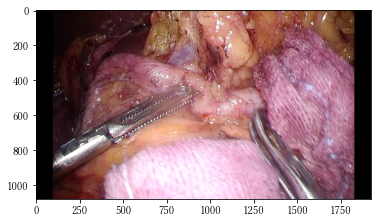

In [12]:
plt.imshow(frame)

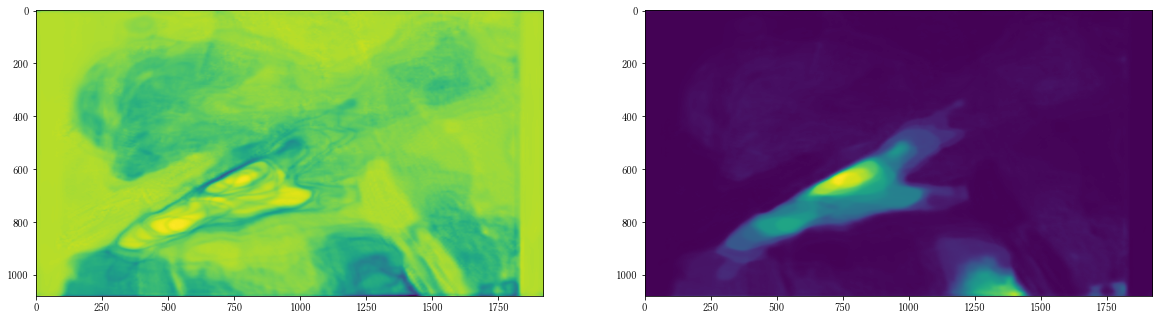

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(1 - Y_uncertainty)
axes[1].imshow(Y_pred)

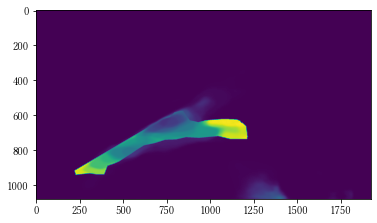

In [14]:
plt.imshow(np.power(mask - Y_pred, 2))

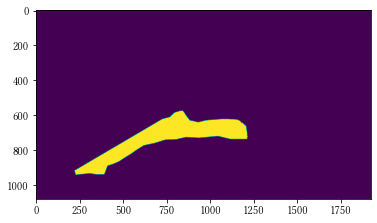

In [15]:
plt.imshow(mask)

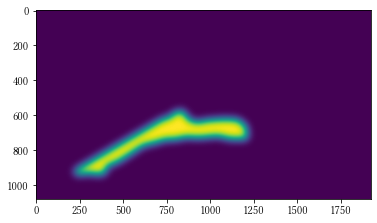

In [55]:
# mask2 = cv2.GaussianBlur(mask.astype(np.float32), (155, 155), 0)
# mask2 = cv2.blur(mask, (155, 155))
# mask2 = cv2.medianBlur(mask, 5)
plt.imshow(mask2)

In [95]:
def KLD(P, Q, e=1e-6):
    return np.sum(P * (np.log(P + e) - np.log(Q + e)))

def KLMetrics(Y_pred, mask):
    n = 10
    box = np.min(mask.shape)
    scores = []
    for i in range(1, n+1):
        size = box // i
        if size % 2 == 0:
            size += 1
        mask2 = cv2.GaussianBlur(mask.astype(np.float32), (size , size), 0)

        score = KLD(mask2, Y_pred)
        scores.append(score)

    return np.mean(scores)

In [105]:
def dice2_pytorch_with_sigmoid_each_data(Y_pred, Y, threshold=0.5, e=1e-6):
#     Y_pred = Y_pred.sigmoid().squeeze(1)
    Y = Y.squeeze(1)
    Y = torch.where(Y > threshold, 1, 0).long()
    Y_pred = Y_pred.squeeze(1)
    Y_pred = torch.where(Y_pred > threshold, 1, 0).long()
    
    intersection = (Y_pred & Y).float().sum((1, 2))
    pred_sum = Y_pred.sum((1, 2))
    target_sum = Y.sum((1, 2))
    
    f = (2. * intersection + e) / (pred_sum + target_sum + e)
    return f.cpu().numpy()

def DiceMetrics(Y_pred, mask):
    n = 10
    box = np.min(mask.shape)
    scores = []
    for i in range(1, n+1):
        size = box // i
        if size % 2 == 0:
            size += 1
        mask2 = cv2.GaussianBlur(mask.astype(np.float32), (size , size), 0)

        score = dice2_pytorch_with_sigmoid_each_data(torch.Tensor(Y_pred).unsqueeze(0), torch.Tensor(mask2).unsqueeze(0))
        scores.append(score)

    return np.mean(scores)

In [106]:
KLMetrics(Y_pred, mask)

95143.164

In [107]:
DiceMetrics(Y_pred, mask)

0.20559072

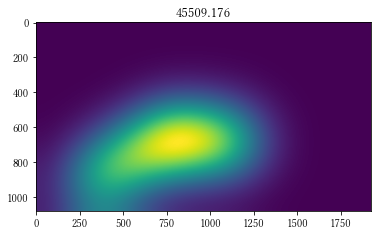

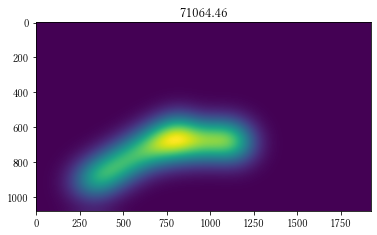

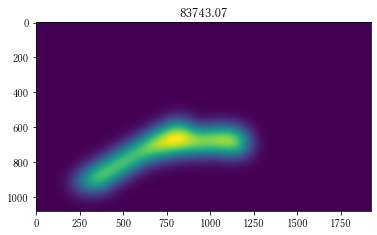

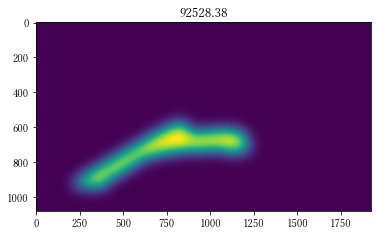

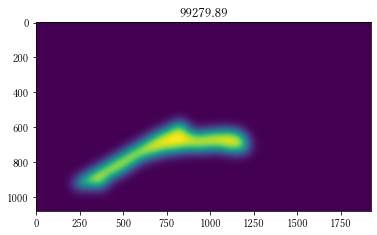

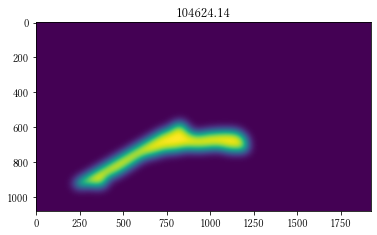

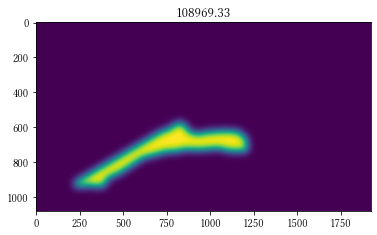

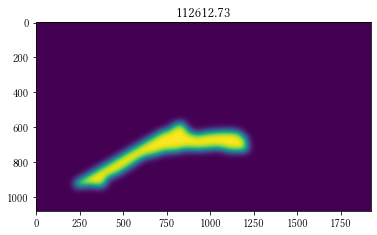

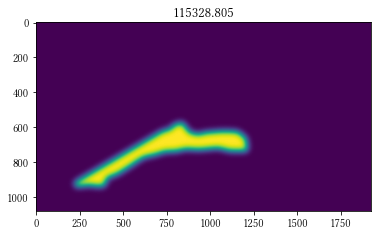

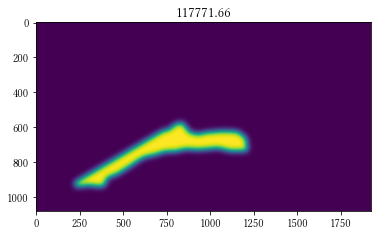

95143.164


In [98]:
n = 10
box = np.min(mask.shape)
scores = []
for i in range(1, n+1):
    size = box//i
    if size % 2 == 0:
        size += 1
    mask2 = cv2.GaussianBlur(mask.astype(np.float32), (size , size), 0)
    
    score = KLD(mask2, Y_pred)
    scores.append(score)
    
    plt.title(score)
    plt.imshow(mask2)
    plt.show()
    
print(np.mean(scores))

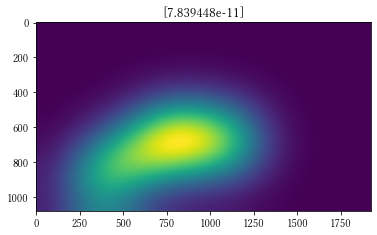

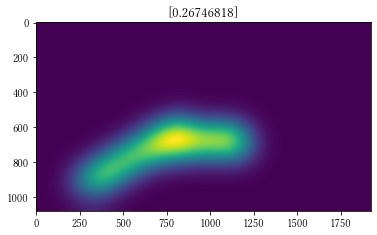

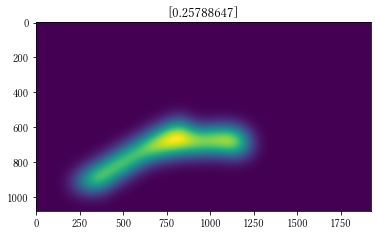

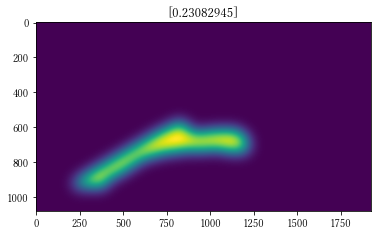

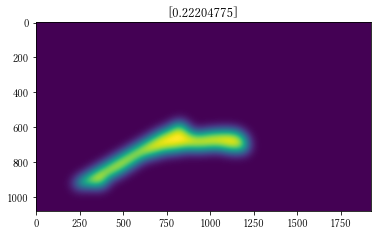

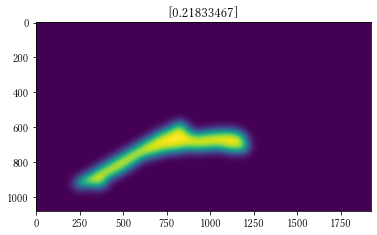

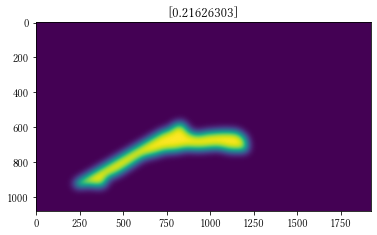

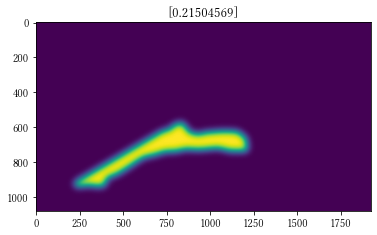

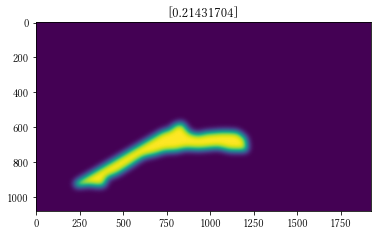

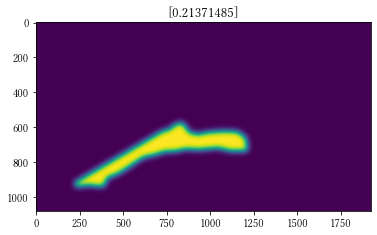

0.20559072


In [104]:
n = 10
box = np.min(mask.shape)
scores = []
for i in range(1, n+1):
    size = box//i
    if size % 2 == 0:
        size += 1
    mask2 = cv2.GaussianBlur(mask.astype(np.float32), (size , size), 0)
    
    score = dice2_pytorch_with_sigmoid_each_data(torch.Tensor(Y_pred).unsqueeze(0), torch.Tensor(mask2).unsqueeze(0))
    scores.append(score)
    
    plt.title(score)
    plt.imshow(mask2)
    plt.show()
    
print(np.mean(scores))

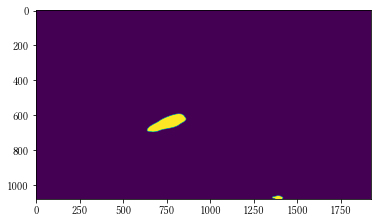

In [91]:
plt.imshow(Y_pred > 0.5)

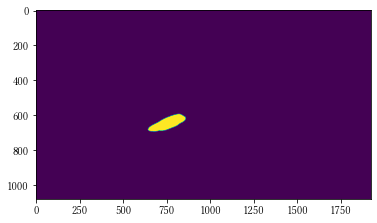

In [18]:
t = (1 - Y_uncertainty).mean()
Y_pred2 = (1 - Y_uncertainty) * Y_pred > t * 0.5
plt.imshow(Y_pred2)

In [19]:
Y = mask

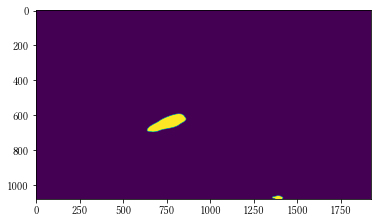

In [20]:
plt.imshow(Y_pred > 0.5)

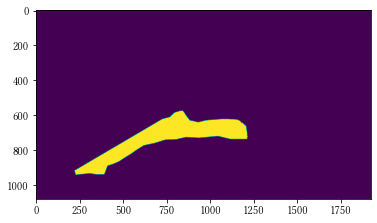

In [21]:
plt.imshow(mask)

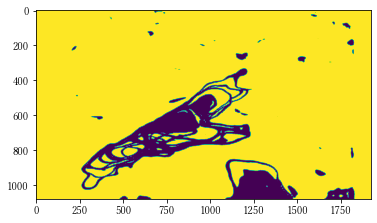

In [22]:
plt.imshow(Y_uncertainty_max < 0.7)

In [30]:
def ft_precision_pytorch_with_sigmoid_each_data(Y_pred, Y, e=1e-6):
#     Y = cv2.GaussianBlur(Y.squeeze(0).numpy(), (1, 1), 0)
    Y = torch.Tensor(Y).unsqueeze(0)
    Y = Y.squeeze(1)
    Y_pred = Y_pred.sigmoid().squeeze(1)
    
    intersection = (Y_pred * Y).float().sum((1, 2))
    pred_sum = Y_pred.sum((1, 2))
    
    precision = (intersection + e) / (pred_sum + e) 
    return precision.cpu().numpy()

def ft_recall_pytorch_with_sigmoid_each_data(Y_pred, Y, e=1e-6):
#     Y = cv2.GaussianBlur(Y.squeeze(0).numpy(), (1, 1), 0)
    Y = torch.Tensor(Y).unsqueeze(0)
    Y = Y.squeeze(1)
    Y_pred = Y_pred.sigmoid().squeeze(1)
    
    intersection = (Y_pred * Y).float().sum((1, 2))
    pred_sum = Y.sum((1, 2))
    
    precision = (intersection + e) / (pred_sum + e) 
    return precision.cpu().numpy()

def ft_f_pytorch_with_sigmoid_each_data(Y_pred, Y, e=1e-6):
#     Y = cv2.GaussianBlur(Y.squeeze(0).numpy(), (1, 1), 0)
    Y = torch.Tensor(Y).unsqueeze(0)
    Y = Y.squeeze(1)
    Y_pred = Y_pred.sigmoid().squeeze(1)
    
    intersection = (Y_pred * Y).float().sum((1, 2))
    pred_sum = Y.sum((1, 2)) + Y_pred.sum((1, 2))
    
    precision = (2 * intersection + e) / (pred_sum + e) 
    return precision.cpu().numpy()

In [31]:
print(precision_pytorch_with_sigmoid_each_data(torch.Tensor(Y_pred).unsqueeze(0), torch.Tensor(Y).unsqueeze(0)).item())
print(recall_pytorch_with_sigmoid_each_data(torch.Tensor(Y_pred).unsqueeze(0), torch.Tensor(Y).unsqueeze(0)).item())
print(f_pytorch_with_sigmoid_each_data(torch.Tensor(Y_pred).unsqueeze(0), torch.Tensor(Y).unsqueeze(0)).item())


0.047252122312784195
1.0
0.09024020284414291


In [32]:
print(ft_precision_pytorch_with_sigmoid_each_data(torch.Tensor(Y_pred).unsqueeze(0), torch.Tensor(Y).unsqueeze(0)).item())
print(ft_recall_pytorch_with_sigmoid_each_data(torch.Tensor(Y_pred).unsqueeze(0), torch.Tensor(Y).unsqueeze(0)).item())
print(ft_f_pytorch_with_sigmoid_each_data(torch.Tensor(Y_pred).unsqueeze(0), torch.Tensor(Y).unsqueeze(0)).item())


0.052262283861637115
0.5694330334663391
0.09573780000209808
